Wiki crawled at night of 10/june/2019

In [0]:
!pip install sentencepiece
!pip install tf_sentencepiece

     |████████████████████████████████| 1.0MB 3.4MB/s 
     |████████████████████████████████| 2.8MB 3.4MB/s 


In [0]:
!pip install fastai==1.0.52
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm

     |████████████████████████████████| 225kB 3.4MB/s 
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
wiki=path/'Thesis Data'/'wiki_data'/'Wiki'
subsets = aa/'subsets'

In [0]:
subsets.ls()

## Load SP

In [0]:
vocab_size = 30000
model_prefix = 'sp_wiki'

In [0]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [0]:
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [0]:
len(itos)

30000

In [0]:
itos[:5], itos[-5:]

(['<unk>', '<s>', '</s>', '▁', '।'],
 ['এইচএসপিএ', '▁ইকরিমা', '▁উস্কানি', '▁বাদানুবাদ', '/'])

In [0]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [0]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [0]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [0]:
bs = 32
bptt = 70

## 6 Authors

### LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '6train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('6train_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '6train_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁আজ ▁আমার ▁নিজের ▁শরীর ও ▁ভাল ▁নয় । ▁মনে ▁করছি , ▁তাঁর ▁ঘরে ▁খাবার ▁ঢাকা ▁দিয়ে ▁রেখে ▁একটু ▁শো ব । ▁ও ঠো , ▁তো মা কে ▁খাইয়ে ▁দি ই ▁গে , ▁বল িয়া ▁সে ▁কাছে ▁ আসিয়া ▁বই খানা ▁দিবা কর ের ▁ মুখের ▁উপর ▁হইতে ▁তুল িয়া ▁ ল ইল । ▁অদূরে ▁দিবা কর ের ▁লোহার ▁ তোর ঙ্গ টা ▁ছিল । ▁কিরণ ময়ী ▁ফি রিয়া ▁ আসিয়া"
1,▁অনেক ▁বেশী । ▁হরি শ ▁মুখ ুজ ্যের ▁চরিত্রে ▁আরও ▁অনেক ▁রকম ▁বৈপরীত্য ▁আছে । ▁দেশের ▁সাধারণ ▁মানুষের ▁দুঃখ ▁দূর ▁করার ▁জন্য ▁তিনি ▁তাঁর ▁লেখনী কে ▁তরবারি ▁করে ▁তুল ছেন ▁দিন ▁দিন । ▁ব্ৰ া হ্ম ▁ধর্ম ▁প্রচারের ▁জন্য ▁তিনি ▁দৃঢ়ভাবে ▁নিয়ম নিষ্ঠ । ▁সপ্তাহে ▁অন্তত ▁দু দিন ▁তিনি ▁ র সা পা গলা ▁অঞ্চল ▁ সন্নিহিত ▁ভবানীপুর ে ▁ব্রাহ্ম ▁মন্দিরে ▁উপাসনার ▁পূর্বে ▁বক্তৃতা ▁করেন । ▁হিন্দু ▁পেট্রিয়ট ের ▁পৃষ্ঠা
2,"টা ▁মেজ দার । ▁একটু ▁ হাঁ কা হাঁ কির ▁পর ▁বাবার ▁কথা ▁শোনা ▁গেল , ▁সে ▁নেই । ▁নেই ▁মানে ? ▁মা ▁কোথায় ▁গেল ? ▁ তোর ▁দাদার ▁সঙ্গে ▁তার কে শ্বর ে ▁গিয়েছে । ▁সাবা স ! ▁তোমার ▁বাড়ির ▁হাল চাল ▁কি রকম ! ▁বা ▁বা ▁কোন ▁জবাব ▁দিল ▁না । ▁মেজ দা ▁এবার ▁তার ▁বউ কে ▁ডাক তে ▁ডাক তে ▁ঘরে ▁ঢু কল । ▁একটা ▁প্রাণবন্ত ▁মানুষ"
3,"▁তাদেরকে ▁অ পদস্থ ▁করবার ▁চেষ্টায় ▁ টল ম লে ▁ব্যাবসা কে ▁ কাত ▁করে ▁ফেলা ▁হয় । ▁সেই রকম ▁চেষ্টা ▁চলবে ▁মধুসূদন ▁তা ▁বুঝে ছিল । ▁মাদ্রাজ - ব ্যাঙ্ক ের ▁বিপর্যয় ে ▁ঘোষাল - কোম্পানি র ▁লোক সান ের ▁পরিমাণ ▁যে ▁কতটা ▁দাঁড়াবে ▁এখনো ▁তা ▁নিশ্চিত ▁জান বার ▁সময় ▁হয় ▁নি , ▁কিন্তু ▁মধুসূদন ের ▁প্রতিপত্তি ▁নষ্ট ▁করবার ▁আয়োজনে ▁এও ▁যে ▁একটা ▁মসলা ▁ জোগ াবে ▁তাতে ▁সন্দেহ ▁ছিল"
4,"▁করল , ▁কারণ ▁এ ▁ছাড়া ▁আর ▁কিছু ▁করার ▁ছিল ▁না । ▁এক ▁সপ্তাহ ▁সময় ▁শেষ ▁হয়ে ▁গেছে । ▁আর ▁ঘন্টা খানেক ▁পরে ▁জাহিদ ের ▁ হাক শী কে ▁সবকিছু ▁ঠিক ▁করে ▁বুঝিয়ে ▁দেয়ার ▁কথা । ▁এই ▁একটি ▁সপ্তাহ ▁জাহিদ ▁আর ▁কামাল ▁প্রায় ▁জন ▁ত্রিশ েক ▁টেক নি শিয়ান কে ▁নিয়ে ▁কাজ ▁করেছে । ▁যদিও ▁রি - অ ্যাক্ট র ের ▁ত্রুটি টি ▁ছিল ▁সাধারণ , ▁কিন্তু ▁কামাল ▁টেক নি শিয়ান"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


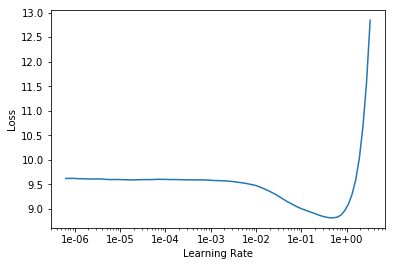

In [0]:
learn.freeze()
learn.lr_find();
learn.recorder.plot();

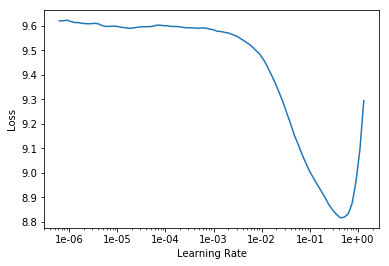

In [0]:
learn.recorder.plot(skip_end=10);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_subword_lm_body_2');
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2)
learn.save('6train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,5.241946,5.119304,0.204207,07:12
1,4.980522,4.847491,0.226773,07:13


epoch,train_loss,valid_loss,accuracy,time
0,4.938299,4.786325,0.234194,07:24
1,4.615206,4.529509,0.260692,07:24


epoch,train_loss,valid_loss,accuracy,time
0,4.751803,4.645832,0.248779,07:59
1,4.367792,4.362436,0.279900,07:59


epoch,train_loss,valid_loss,accuracy,time
0,4.293935,4.354998,0.278879,08:20
1,4.515825,4.501368,0.261239,08:20
2,4.563277,4.543374,0.257256,08:20


KeyboardInterrupt: ignored

In [0]:
learn.load('6train_wiki_subword_lm_body_2');
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)
learn.save('6train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.186925,4.342703,0.282287,08:21
1,4.257757,4.307171,0.285517,08:20
2,4.156099,4.270999,0.288811,08:20
3,4.077569,4.237844,0.292275,08:20
4,4.049616,4.210957,0.295468,08:20
5,4.002124,4.192326,0.297832,08:20
6,3.883562,4.178176,0.299730,08:20
7,3.827266,4.174410,0.300626,08:20
8,3.785978,4.173587,0.300924,08:20
9,3.803638,4.174279,0.300909,08:20


In [0]:
learn.load('6train_wiki_subword_lm_body_3');
learn.save_encoder('6train_wiki_subword_lm_enc')

### Classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '6train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('6train_subword_wiki_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"▁xx bo s ▁হত ! ▁আমার ▁সঙ্গে ▁তাঁর ▁তুলনা ! ▁নৃ প বালা । ▁আ চ্ছা ▁মুখ ুজ ্যে ম শায় , ▁এত ক্ষণ ▁তুমি ▁এখানে ▁বসে ▁বসে ▁কী ▁করছিল ে ? ▁অক্ষয় । ▁তো দের ▁গ য় লা বাড়ির ▁দুধ ের ▁হিসেব ▁লিখ ছিল ুম । ▁ নীর বালা । ▁( ডে স্ক ের ▁উপর ▁হইতে ▁অসম া প্ত ▁চিঠি ▁তুল িয়া ▁লইয়া ) ▁এই ▁তোমার ▁গ য় লা",robindronath
"▁xx bo s ▁ কে হ ▁বিশ্বাস ▁করিয়া ছে , ▁ কে হ ▁করে ▁নাই । ▁প্রাঙ্গণে ▁মোটর ▁দাঁড় াইয়া । ▁কাছে , ▁দূরে ▁ বাটী র ▁সকলেই ▁উপস্থিত । ▁মেয়েরা ▁দ্বিতল ের ▁বারান্দা য় ▁দাঁড় াইয়া ▁চোখ ▁মু ছি তে ছে , ▁বি প্র দাস ▁উ ঠি তে ▁ গিয়া ▁জিজ্ঞাসা ▁করি লেন , ▁দ্বি জু কে ▁দে খ চি ▁নে ▁কেন ? ▁ কে ▁একজন ▁বলি ল ,",shorotchandra
"▁xx bo s ▁শু নিল ▁না , ▁দ্রুত পদে ▁ও ডিক লোন ▁বরফ জল ে ▁মিশা ইয়া ▁উপস্থিত ▁করি ল । ▁আশা র ▁হাতে ▁ভি জা ▁রুম াল ▁দিয়া ▁ ক হিল , ▁“ মহ েন্দ্র বাবুর ▁মাথায় ▁বাঁধ িয়া ▁দাও । ” ▁মহেন্দ্র ▁বারবার ▁বলি তে ▁লা গিল , ▁“ থা ক্ ▁ - না । ” ▁বিহারী ▁অবরুদ্ধ হাস ্যে ▁নীরব ে ▁অভিনয় ▁দেখি তে ▁লা গিল ।",robindronath
"▁xx bo s ▁নিয়ম ▁চল ি বে ▁নাকি ?” ▁সকলেই ▁ভাব িল , ▁অবনতি র ▁লক্ষণ ▁ইহা ▁হইতে ▁আর ▁কী ▁হইতে ▁পারে ! ▁মগ ে ▁হিন্দু তে ▁ ত ফাত ▁ র হিল ▁কী ! ▁ভুবনেশ্বর ী - দেবী - মন্দির ের ▁ ভ ৃত ্য ▁জয় সিংহ ▁জাতি তে ▁রাজপুত , ▁ক্ষত্রিয় । ▁তাঁহার ▁বা প ▁সু চে ত সিংহ ▁ত্রিপুরা য় ▁রাজ বাটী র ▁একজন ▁পুরাতন ▁ ভ",robindronath
"▁xx bo s ▁“ অ ভাব ▁কী । ▁আমার ই ▁তো ▁ভা সুর ের ▁এক ▁মেয়ে ▁আছে , ▁যেমন ▁সুন্দরী ▁তেমনি ▁লক্ষ্মী । ▁ মেয়েটির ▁বয়স ▁হইল , ▁কেবল ▁উপযুক্ত ▁বর ের ▁প্রত্যাশা য় ▁অপেক্ষা ▁করিয়া ▁আছে ; ▁তোমার ▁মতো ▁কুল ীন ▁পাইল ে ▁এখন ি ▁বিবাহ ▁দিয়া ▁দেয় । ” ▁স্বামী ▁চক িত ▁হইয়া ▁ ক হি লেন , ▁“ বিবাহের ▁কথা ▁ কে ▁বলি তে ছে । ”",robindronath


In [0]:
data_clas = load_data(subsets, '6train_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('6train_wiki_subword_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


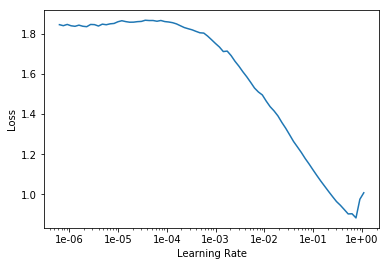

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('6train_wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('6train_wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('6train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('6train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.218127,0.020512,0.994324,05:04
1,0.087994,0.004193,1.000000,05:02


epoch,train_loss,valid_loss,accuracy,time
0,0.061809,0.001463,0.999054,05:51
1,0.021825,0.002620,0.999054,05:57


epoch,train_loss,valid_loss,accuracy,time
0,0.021776,0.002078,0.999054,08:47
1,0.017780,0.001020,0.999054,08:52


epoch,train_loss,valid_loss,accuracy,time
0,0.010451,0.001137,1.000000,11:24
1,0.006800,0.001352,0.999054,11:16
2,0.010079,0.000688,1.000000,11:10
3,0.011641,0.000553,1.000000,11:25


In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'6test.csv')

1320
Accuracy: 
0.9962121212121212
[('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('shunil_gongopaddhay', 'robindronath')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out , out.mean()

(array([0.997732, 0.995434, 0.993166, 1.      , 0.995475, 0.995455]),
 0.9962103603084759)

## 8 Authors

### LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '8train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('8train_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '8train_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁কেউ - না - কে উ ▁গ্রন্থের ▁পাঠোদ্ধার ▁করতে ▁পারবে । ▁দুই ▁ও ঁড় ের ▁ হস্তী শা বক ▁দেখে ও ▁তিনি ▁উত্তেজিত । ▁প্রকৃতির ▁বিশেষ ▁খেয়াল ে ▁এরকম ▁একটি ▁ হস্তী শা বক ের ▁জন্ম ▁হয়েছে , ▁নাকি ▁এটি ▁বিশেষ ▁কোনো ▁প্ৰ জাতি র ? ▁বিষয়টি ▁নিয়ে ▁ব্যাপক ▁অনুসন্ধান ▁হওয়া ▁প্রয়োজন । ▁হরি মতি ▁এখন ▁আছে ▁আক িকা ▁বেগম ের ▁তত্ত্বাবধানে । ▁আক িকা । ▁বেগম ▁এবং ▁তার ▁বান্ধবী"
1,"স্তি ▁নয় ▁ভাই , ▁তোমার ▁মুক্তি ▁হইবে । ▁যতদিন ▁তুমি ▁তোমার ▁স্বামীর ▁কাছে ▁আপনাকে ▁গোপন ▁করিয়া ▁রাখি তে ছ ▁ততদিন ▁তুমি ▁আপনাকে ▁একটা ▁মিথ্যা র ▁বন্ধনে ▁জড়িত ▁করিতে ছ - তা হা ▁তেজ ের ▁সহিত ▁ ছি ঁ ড়িয়া ▁ফেলো , ▁ঈশ্বর ▁তোমার ▁মঙ্গল ▁করি বেন ই । ” ▁কমলা ▁ ক হিল , ▁“ আবার ▁পা ছে ▁সব ▁হার াই ▁এই ▁ভয় ▁যখন ▁মনে ▁আসে ▁তখন ▁সব ▁বল ▁চল"
2,"গুলো ▁খুঁজতে ▁ও কে ▁এখন ▁হাত ড়া তে ▁হচ্ছে । ▁অনি মেষ ▁আবিষ্কার ▁করল , ▁ও র ▁সঙ্গে ▁রে তিয়া র ▁এই ▁মুহূর্তে ▁কোনো ▁পার্থক্য ▁নেই - দু জন েই ▁এই ▁মুহূর্তে ▁অন্ধ । ▁ছোট মা ▁বোধ হয় ▁আগে ▁থেকেই ▁বিছানা পত্র ▁ঠিক ▁করে ▁রেখেছিলেন । ▁মহী তোষ ের ▁একটা ▁পুরনো ▁হো ন্ডল ▁ছিল , ▁সেটাই ▁পরিস্কার ▁করে ▁বিছানা পত্র ▁ঢুকিয়ে ▁বেঁধে ▁দেওয়া ▁হল । ▁ ঝাড় িকা কু ▁সেটা"
3,"ছে , ▁গায়ে র ▁রং ▁তামাটে ▁মেরে ▁এল — এ ▁তো ▁ভাল ▁লক্ষণ ▁নয় । ▁কিছু ▁একটা ▁হয়েছে ▁আপনার , ▁মুখে ▁বলছেন ▁না । ▁তা ▁তো ▁হয়েছে ই । ▁কী ▁মনে ▁হচ্ছে ▁ জানো ? ▁এই ▁দুনিয়া য় ▁জন্মে ▁এত কাল ▁দুনিয়া টাকে ▁চিন বার ▁চেষ্টা ই ▁করি নি , ▁দুনিয়া টার ▁ভাল - মন্দ ▁নিয়ে ▁ভাব িও নি ▁কিছু , ▁এত ▁যে ▁মানুষজন ▁তাদের ▁সঙ্গে ▁সম্পর্ক ও ▁তৈরি ▁করি"
4,"bo s ▁সর্ব নাশ ের ▁বিশাল তা ▁দেখে ▁ কে ▁অতীত - ভবিষ্যৎ ▁ভুলে ▁যায় । ▁বড় ▁বিপদের ও ▁এক ▁প্রচণ্ড ▁সম্ মোহন শক্তি ▁আছে । ▁জলের ▁ পিণ্ড ▁এগিয়ে ▁এল ▁আরও ▁কাছে । ▁শ্রী নাথ ▁ভেবে ছিল ▁খুব ▁কাছেই ▁কোথাও ▁পড়বে । ▁তা ▁পড়ল ▁না । ▁যতক্ষণ ▁ধরে ▁শূন্য ▁পে রো চ্ছিল ▁ততক্ষণ ে ▁আহ্নিক ▁গতির ▁বশ ে ▁পৃথিবী ▁একটু ▁ঘুরে ▁গেছে । ▁তবু , ▁খুব ▁দূরে ▁নয় ,"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


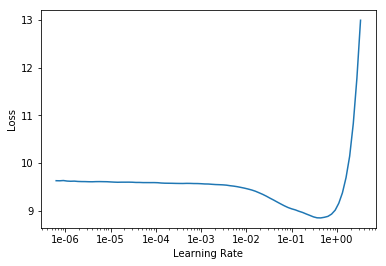

In [0]:
learn.freeze()
learn.lr_find();
learn.recorder.plot();

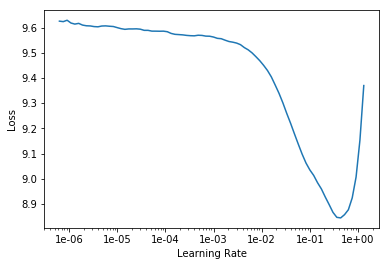

In [0]:
learn.recorder.plot(skip_end=10);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,5.384848,5.263005,0.190835,15:39
1,5.109797,4.992914,0.213728,15:40


epoch,train_loss,valid_loss,accuracy,time
0,5.052078,4.937386,0.219858,16:00
1,4.749715,4.684236,0.244610,16:09


epoch,train_loss,valid_loss,accuracy,time
0,4.796930,4.804179,0.233232,17:22
1,4.497572,4.521537,0.262414,17:22


In [0]:
learn.unfreeze()
learn.fit_one_cycle(6, 1e-3)
learn.save('8train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.376826,4.493676,0.265231,18:15
1,4.310618,4.446989,0.269500,18:15
2,4.268217,4.403807,0.273829,18:15
3,4.143509,4.374350,0.277910,18:15
4,4.134327,4.361048,0.279715,18:16


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('8train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.130495,4.366357,0.278420,18:15
1,4.111199,4.346968,0.280725,18:14
2,4.010805,4.327387,0.283665,18:14
3,3.921455,4.325974,0.284113,18:16


In [0]:
learn.save_encoder('8train_wiki_subword_lm_enc')

### Classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '8train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('8train_subword_wiki_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"▁xx bo s ▁ কে হ ▁বিশ্বাস ▁করিয়া ছে , ▁ কে হ ▁করে ▁নাই । ▁প্রাঙ্গণে ▁মোটর ▁দাঁড় াইয়া । ▁কাছে , ▁দূরে ▁ বাটী র ▁সকলেই ▁উপস্থিত । ▁মেয়েরা ▁দ্বিতল ের ▁বারান্দা য় ▁দাঁড় াইয়া ▁চোখ ▁মু ছি তে ছে , ▁বি প্র দাস ▁উ ঠি তে ▁ গিয়া ▁জিজ্ঞাসা ▁করি লেন , ▁দ্বি জু কে ▁দে খ চি ▁নে ▁কেন ? ▁ কে ▁একজন ▁বলি ল ,",shorotchandra
"▁xx bo s ▁মাকে । ▁তাকে ▁বলে ▁যা চ্চি ▁কি ▁হয়ে চে । ▁এই ▁বল িয়া ▁নাতি নী কে ▁দেখা ইয়া ▁ ক হি লেন , ▁এই ▁যে ▁মেয়ে টা ▁মঙ্গলবার ের ▁বার বেলা য় ▁ছাগল দ ড়ি ▁ডি ঙ িয়ে ▁ফেললে , ▁ওই ▁যে ▁দু লে ▁ছু ড়ী ▁আঁচ ল ▁ঘুরিয়ে ▁বা ছা কে ▁ছুঁয়ে ▁দিলে — ▁সন্ধ্যা ▁দু লে ▁মেয়ে টাকে ▁জিজ্ঞাসা ▁করি ল , ▁তু ই ▁ছুঁয়ে",shorotchandra
"▁xx bo s ▁টান িয়া ▁কোলা কুলি ▁করি ল । ▁রাজ লক্ষ্মী ▁ ক হি লেন , ▁“ মহ িন , ▁আমি ▁তো কে ▁এই ▁আর্ শী র্ বাদ ▁করি – শিশু কাল ▁হইতে ▁বিহারী ▁ তোর ▁যেমন ▁বন্ধু ▁ছিল , ▁চিরকাল ▁তেমনি ▁বন্ধু ▁থাক ্ ▁ - ই হার ▁চেয়ে ▁ তোর ▁সৌভাগ্য ▁আর - কিছু ▁হইতে ▁পারে ▁না । ” ▁এই ▁বল িয়া ▁রাজ লক্ষ্মী ▁অত্যন্ত ▁ক্লান্ত ▁হইয়া",robindronath
"▁xx bo s ▁মাথায় ▁হাঁড়ি ▁নাই , ▁হাঁড়ি টা ▁মুহূর্তে র ▁মধ্যে ▁হাতে ▁হাতে ▁কত দূর ▁চল িয়া ▁ গিয়া ছে ▁তাহার ▁ঠিকানা ▁নাই — ▁দই ওয়ালা ▁খান িক ক্ষণ ▁ হাঁ ▁করিয়া ▁চা হিয়া ▁ র হিল । ▁একজন ▁বলি ল , ▁‘ ভাই , ▁তুমি ▁দই য়ের ▁বদলে ▁ ঘো ল ▁খা ইয়া ▁গেলে , ▁ কিঞ্চিৎ ▁লোক সান ▁হইল ▁বৈ ▁তো ▁নয় ! ’ ▁দই ওয়ালা ▁পরম",robindronath
"▁xx bo s ▁বুকের ▁কাছে ▁মাঝে ▁মাঝে ▁একটা ▁ব্যথা ▁টের ▁পাই । ▁চন্দ্র নাথ ▁বলি ল , ▁আর ▁ঐ ▁ মূর্ ছা টা ? ▁সর য ূ ▁হাসি ল , ▁ও টা ▁কিছুই ▁নয় । ▁চন্দ্র নাথ ▁মনে ▁মনে ▁বলি ল , ▁যা ▁হই বার ▁হইয়া ছে , ▁এখন ▁ সর্বস্ব ান্ত ▁হইয়া ও ▁তো মা কে ▁আরোগ্য ▁করি ব । ▁সর য ূ ▁ ক হিল , ▁তোমার ▁কাছে",shorotchandra


In [0]:
data_clas = load_data(subsets, '8train_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('8train_wiki_subword_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


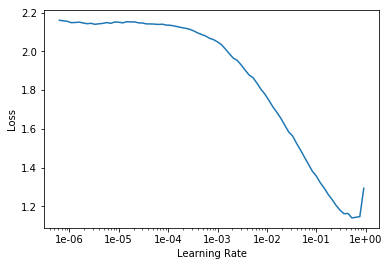

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('8train_wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.8**4),1e-2), moms=(0.8,0.7))
learn_cls.save('8train_wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.8**4),5e-3), moms=(0.8,0.7))
learn_cls.save('8train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.8**4),1e-3), moms=(0.8,0.7))
learn_cls.save('8train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.168106,0.005710,0.999160,05:40
1,0.059853,0.003431,1.000000,05:44


epoch,train_loss,valid_loss,accuracy,time
0,0.090093,0.003922,0.999160,06:33
1,0.031359,0.001195,1.000000,06:36


epoch,train_loss,valid_loss,accuracy,time
0,0.019961,0.001271,0.999160,09:55
1,0.014047,0.000491,1.000000,09:58


epoch,train_loss,valid_loss,accuracy,time
0,0.011813,0.000092,1.000000,12:48
1,0.009357,0.000112,1.000000,12:39
2,0.011731,0.000118,1.000000,12:48
3,0.003889,0.000141,1.000000,12:54


In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'8test.csv')

1496
Accuracy: 
0.9966577540106952
[('shirshendu', 'shunil_gongopaddhay'), ('MZI', 'humayun_ahmed'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'shomresh')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out , out.mean()

(array([0.994652, 0.989247, 1.      , 0.997319, 0.997333, 0.997333, 0.997333, 1.      ]),
 0.996652344137202)

## 10 Authors

### LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '10train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('10train_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '10train_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁উপর ▁বস িয়া ছেন , ▁সম্মুখে ▁উন্মুক্ত ▁পুঁথি । ▁তিনি ▁একবার ▁প্রশান্ত ▁ চ ক্ষে ▁সভার ▁চারিদিকে ▁দৃষ্টি ▁নিক্ষেপ ▁করি লেন , ▁তারপর ▁ ম ন্দ্র কণ্ঠ ে ▁পাঠ ▁আরম্ভ ▁করি লেন — ▁অস্ত ্য ত্তর স ্যাং ▁দি শি ▁দেবতা ত্ মা ▁হিমালয় ো ▁নাম ▁ ন গা ধি রাজ ঃ । ▁মহিলা মঞ্চ ের ▁মধ্যস্থলে ▁ কুন্তল কুমারী ▁নির্ নির্ ম ষ ▁নে ত্রে ▁নিম্নে ▁কালিদাসের ▁পান ে"
1,"▁কাঁদ িতে ▁লা গিল , ▁ভালো ▁বুঝি ল ▁না । ▁হত া শ্বাস ▁রামমোহন ▁ আসিয়া ▁ম্লান মুখে ▁ ক হিল , ▁“ মা , ▁তবে ▁চল ি লাম । ▁মহারাজ কে ▁ গিয়া ▁কী ▁বলি ব । ” ▁বি ভা ▁কিছু ▁বলি তে ▁পারি ল ▁না , ▁অনেক ক্ষণ ▁নি রু ত্তর ▁হইয়া ▁ র হিল । ▁রামমোহন ▁ ক হিল , ▁“ তবে ▁বিদায় ▁হই ▁মা । ”"
2,"। ▁হাত ▁তুল িয়া ▁সঙ্কেত ▁করি লেন । ▁তিনটি ▁মাথা ▁কিছুক্ষণ ▁শয্যা র ▁উপর ▁একত্র ▁হইয়া ▁ র হিল । ▁শেষে ▁বীর শ্রী ▁বলি লেন — দি দি , ▁বাইরে ▁বড় ▁অন্ধকার , ▁কোথায় ▁যাচ্ছি ▁বুঝতে ▁পার ছি ▁না । ▁ভয় ▁হচ্ছে , ▁যদি ▁ধরা ▁পড়ে ▁যাই । ▁ঠাকুর ানী ▁বলি লেন — এক ▁কাজ ▁কর । ▁আমার ▁শিবির ের ▁প্রদীপ ▁দ্বার ের ▁বাইরে ▁নিয়ে ▁গিয়ে ▁রাখ । ▁তবু ▁খানিকটা"
3,ে না । ▁প্রতিটি ▁সংসার ের ▁নিজস্ব ▁কিছু ▁সমস্যা ▁থাকে । ▁বাইরে ▁থেকে ▁দেখলে ▁সেসব ▁সমস্যা ▁আঁচ ▁করা ▁যায় ▁না । ▁ছোট ছেলে কে ▁বিয়ের ▁পর ▁আলাদা ▁সংসার ▁করার ▁অনুমতি ▁দিতে ▁চাননি ▁পর শে চন্দ্র । ▁স্ত্রীর ▁জে দে ▁রাজী ▁হয়েছিলেন । ▁স্ত্রী ▁তাঁকে ▁বুঝিয়ে ছিলেন ▁এতে ▁সম্পর্ক ▁ভাল ▁থাকবে । ▁এবং ▁আছে । ▁বড় ▁ছেলে ▁এখনও ▁বা প - মায়ের ▁অনুরক্ত । ▁কিন্তু ▁তার ▁স্ত্রীর ▁সঙ্গে ▁পরে শ গিন
4,"▁চতুর্ গুণ ▁ দগ্ধ ▁করিতে ▁লা গিল । ▁বিশ্ব ম্ভ র ▁বি ধু ভূষণ ▁অথবা ▁বাংলাদেশের ▁অধিবাসী দি গ কে ▁এই ▁অপরাধের ▁জন্য ▁দায় িক ▁করিতে ▁পারি লেন ▁না ▁– ▁সমস্ত ই ▁এক লা ▁নিজের ▁ স্কন্ধ ে ▁তুল িয়া ▁ ল ই তে ▁হইল , ▁কেবল ▁যে - মেয়ে রা ▁জন্ম িয়া ছে ▁এবং ▁জন্ম ি বে ▁তাহা দি গ কেও ▁ কিঞ্চিৎ ▁ কিঞ্চিৎ ▁অংশ ▁দিলেন । ▁অ"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


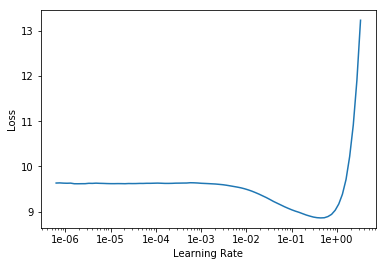

In [0]:
learn.freeze()
learn.lr_find();
learn.recorder.plot();

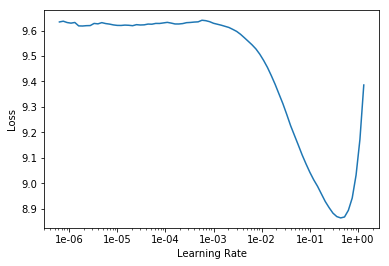

In [0]:
learn.recorder.plot(skip_end=10);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,5.403599,5.221075,0.194153,09:03
1,5.129747,4.938441,0.218514,09:14


epoch,train_loss,valid_loss,accuracy,time
0,5.061222,4.897356,0.224461,09:26
1,4.739140,4.625825,0.251482,09:26


epoch,train_loss,valid_loss,accuracy,time
0,4.854241,4.762018,0.237924,10:11
1,4.529462,4.459123,0.269985,10:11


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('10train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.365697,4.422238,0.273833,10:45
1,4.312780,4.361843,0.279688,10:47
2,4.202605,4.322558,0.284392,10:46
3,4.177186,4.315805,0.285415,10:46


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('10train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.192080,4.320293,0.284387,10:46
1,4.106658,4.291904,0.287026,10:47
2,4.109240,4.263958,0.290645,10:47
3,3.986934,4.260317,0.291493,10:46


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('10train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.081054,4.266046,0.290117,10:47
1,4.039527,4.244548,0.293338,10:46


In [0]:
learn.save_encoder('10train_wiki_subword_lm_enc')

### Classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '10train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('10train_subword_wiki_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"▁xx bo s ▁করিতে ছে । ▁আমার ▁অসি - ফলক ▁অঙ্গ ার ▁হইতে ▁বাহির ▁করিয়া ▁রসায়ন - মি শ্র ▁জলে ▁ ড়ু বাই তে ছে , ▁সন্ত র্প ণে ▁ফলক ের ▁ধার ▁পরীক্ষা ▁করিতে ছে , ▁আবার ▁তাহা ▁অঙ্গ ার মধ্যে ▁প্রোথিত ▁করিতে ছে । ▁তাহার ▁মুখে ▁কথা ▁নাই , ▁কখনও ▁সে ▁সর্প চক্ষু ▁আমার ▁দিকে ▁ ফির াইয়া ▁অতর্কিত ে ▁আমাকে ▁দেখি য়া ▁ ল ই তে ছে ,",shordindu
"▁xx bo s ▁করিয়া ছে । ▁ভিক্ষু ▁কক্ষে ▁প্রবেশ ▁করিয়া ▁সোম দত্ত াকে ▁আ শী বাদ ▁করি লেন ▁এবং ▁আসন ▁পরি গ্রহ ▁করিয়া ▁জি জ্ঞা সু ▁ নো ত্রে ▁তাহার ▁ মুখের ▁প্রতি ▁চা হিয়া ▁ র হি লেন । ▁সংঘ স্থ বির ের ▁বয়স ▁হইয়া ছে , ▁মস্তক ▁ও ▁মুখ ▁ মুণ্ড িত , ▁পরিধান ে ▁পীত বস্ত ্ৰ , ▁শান্ত ▁সৌ ম্য ▁মূর্তি । ▁ কৃ চ্ছ সাধন",shordindu
"▁xx bo s ▁ট্রেনে ই ▁তিনি ▁আসছেন । ▁হো - হে । ’ ▁বল িয়া ▁ ভ্র ূ ▁না চাই লেন । ▁ ব্যোমকেশ ▁একটু ▁বিস্মিত ম্বর ে ▁বলি ল ▁ , ▁‘ কে ▁তিনি ? ’ ▁সুখ ময় বাবু ▁বলি লেন ▁ , ▁‘ তাঁর ▁নাম ▁ ন ফর ▁কুণ্ডু । ▁তাঁর ▁কয়েক ▁ ব স্তা ▁চাল ▁রেল ে ▁চালান ▁যাচ্ছিল ▁ , ▁একটা ▁ ব স্তা ▁ট্রেনের ▁ঝ",shordindu
"▁xx bo s ▁ছা র খার ে ▁দি লি । ” ▁সোম দ ত্তা ▁স্থির ভাবে ▁বলি ল , ▁“ স্ব ী কার ▁করি লাম । ▁কিন্তু ▁আর ▁বিলম্ব ▁করি লে ▁কুমার কে ▁বাঁচা ই তে ▁পারি ব ▁না । ▁ঐ ▁দেখুন , ▁অগ্নি ▁প্রসাদ ▁বেষ্টন ▁করিয়া ছি । ” ▁এই ▁সময় ▁অর্ধ চন্দ্ৰ াকৃতি ▁বা তায় ন পথে ▁অগ্নি র ▁আর ক্ত ▁ লো ল রিস না ▁ও ▁",shordindu
"▁xx bo s ▁ চিত্তে ▁নাড়াচাড়া ▁করিতে ছে , ▁আমি ▁ ই ত্য বস রে ▁টেবিলের ▁উপর ▁হইতে ▁খাতা ▁লইয়া ▁চোখ ▁বু লাই লাম । ▁কবিতার ▁খাতা ▁ , ▁তাহা তে ▁চতুষ্পদ ী ▁জাতীয় ▁কয়েকটি ▁ক্ষুদ্র ▁কবিতা ▁লেখা ▁ র হিয়া ছে । ▁সবগুলি ই ▁অনুরাগ ের ▁কবিতা ▁ , ▁তার ▁মধ্যে ▁একটি ▁মন্দ ▁লা গিল ▁না – ▁গোলাপ ▁ , ▁তোমার ে ▁ধর ি নু ▁বুকের ▁মাঝে ▁বিনিময়ে ▁তুমি",shordindu


In [0]:
data_clas = load_data(subsets, '10train_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('10train_wiki_subword_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


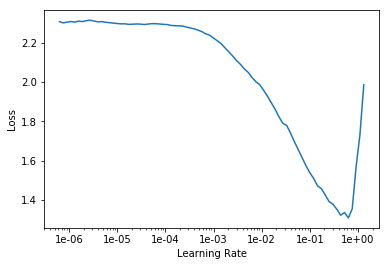

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('10train_wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.8**4),1e-2), moms=(0.8,0.7))
learn_cls.save('10train_wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.8**4),5e-3), moms=(0.8,0.7))
learn_cls.save('10train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.8**4),1e-3), moms=(0.8,0.7))
learn_cls.save('10train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.221031,0.028584,0.993378,03:37
1,0.054487,0.012009,0.996321,03:41


epoch,train_loss,valid_loss,accuracy,time
0,0.091726,0.012617,0.997057,04:04
1,0.032043,0.012164,0.997057,04:10


epoch,train_loss,valid_loss,accuracy,time
0,0.035716,0.007044,0.997792,05:47
1,0.012601,0.007675,0.997792,05:50


epoch,train_loss,valid_loss,accuracy,time
0,0.010965,0.005958,0.997792,07:15
1,0.009940,0.006591,0.997792,07:17
2,0.010165,0.005657,0.997792,07:14
3,0.011313,0.006619,0.997792,07:07


In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'10test.csv')

1700
Accuracy: 
0.9941176470588236
[('shordindu', 'shunil_gongopaddhay'), ('shottojit_roy', 'MZI'), ('shirshendu', 'shordindu'), ('shirshendu', 'shordindu'), ('shirshendu', 'shordindu'), ('MZI', 'humayun_ahmed'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('shunil_gongopaddhay', 'robindronath'), ('shunil_gongopaddhay', 'shordindu')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out , out.mean()

(array([0.988304, 0.99115 , 0.997067, 0.991098, 1.      , 0.985423, 1.      , 0.99705 , 0.99115 , 1.      ]),
 0.9941243238069427)

## 12 Authors

### LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '12train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('12train_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '12train_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁আসছে । ▁বাঘা ▁এমন ▁নিরস্ত্র ▁নিরীহ ▁শিকারের ▁সুযোগ ▁কিছু তে ▁পরিত্যাগ ▁করতে ▁পারছে ▁না । ▁নই লে ▁সে ▁পালা ত । ▁পালা ত ▁দক্ষিণ ▁মুখে , ▁যে দিকে ▁ওই ▁চাষী রা ▁চাষ ▁করছে , ▁ঘোষের া ▁গরু ▁ মহিষের ▁বা থান ▁দিয়ে ▁বসে ▁আছে । ▁ মহিষের ▁শিঙ ে , ▁ঘোষ দের ▁লাঠি তে , ▁দাও য়ের ▁কোপ ে ▁বাঘা ▁মর ত । ▁সর স ▁কৌতুক ে ▁উজ্জ্বল ▁হয়ে ▁উঠল"
1,"▁কেন ? ▁ও দের ▁তো ▁গলা ▁সাধা র ▁কোনও ▁দায় ▁নেই । ▁অন্ধকারে ▁পাশের ▁ঘুম ন্ত ▁বিছানা ▁থেকে ▁জনের ▁গলা ▁ভেসে ▁এল , ▁তুমি ▁কি ▁শেয়াল ের ▁ভাষা ▁বুঝতে ▁পারো ? ▁না । ▁অর্জুন ▁হাস ল । ▁তা ▁হলে ▁ চলো , ▁বাইরে ▁বেরিয়ে ▁দেখা ▁যাক । ▁কৌ ত ূ হল ▁যে ▁হচ্ছিল ▁না ▁তা ▁নয় , ▁কিন্তু ▁শীত ের ▁কথা ▁ভেবে ▁উদ্যোগ ▁নেয়নি ▁অর্জুন । ▁এবার ▁স্লিপিং ▁ব্যাগ ▁থেকে"
2,"▁করে । ▁মানুষ ▁খুন ও ▁করে । ▁ভু ড়ু ▁বলল , ▁সেসব ▁আমি ▁কী ▁জানি ! ▁আমি ▁নিজের ▁হাতে ▁গাছ ও ▁ কাটি ▁না , ▁মানুষ ও ▁খুন ▁করি ▁না । ▁আমার ▁কোনও ▁দায় ▁নেই । ▁বা ঃ , ▁বেশ ▁কথা । ▁কিন্তু ▁যখন ▁এরা ▁পুলিশের ▁হাতে ▁ধরা ▁পড়বে , ▁তখন ▁এদের ▁দলের ▁লোক ▁হিসেবে ▁তুমি ও ▁শাস্তি ▁পাবে । ▁এরা ▁কখনও ▁ধরা ▁পড়বে ▁না । ▁কিছু ▁পুলিশ কে ▁টাকা"
3,"▁বুঝতে ▁পার ছি ▁না । ▁কী ▁বুঝতে ▁পার ছ ▁না ? ▁সৌরজগত ে ▁আমরা ▁ঢুকে ▁গে ছি , ▁মঙ্গল ▁গ্রহের ▁পাশে ▁দিয়ে ▁ছুটে ▁যাচ্ছি ▁কিন্তু ▁তবুও ▁হিসেব ▁মিল ছে ▁না । ▁কী ▁হিসেব ▁মিল ছে ▁না ? ▁গ্রহ গুলো ▁যেখানে ▁থাকার ▁কথা ▁সেখানে ▁নেই । ▁কোথায় ▁আছে ? ▁অন্য ▁জায়গায় । ▁ ঝা ▁শুকনো ▁মুখে ▁বলল , ▁তার ▁মানে ▁কী ? ▁মনে ▁হচ্ছে ▁সময় ▁নিয়ে ▁গোল মাল ▁হয়ে ▁গেছে ।"
4,"▁এসেছিল । ▁হঠাৎ ▁চে ঁচ িয়ে ▁উঠল , ▁চুপ র ও ▁বে য়াদ ব , ▁বা প - মা কে ▁খাওয়া ই ▁নিজের ▁পয়সা য় , ▁তোমার ▁বা পের ▁পয়সা য় ▁নয় । ▁বেশি ▁কথা ▁কই লে ▁মুখ ▁ভেঙে ▁দেব ো । ▁মাও ▁ছাড় বার ▁ পাত্রী ▁নয় । ▁বলল , ▁মুখ ▁ভাঙ বে ! ▁ইস ▁কত ▁মু রোদ , ▁বট তলা র ▁গু ণ্ডা রা ▁তো ▁কান ▁ধরে ▁ও"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


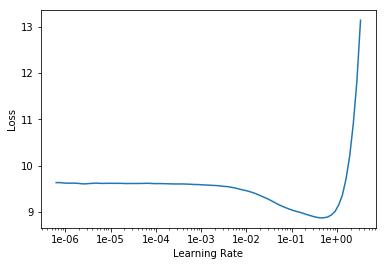

In [0]:
learn.freeze()
learn.lr_find();
learn.recorder.plot();

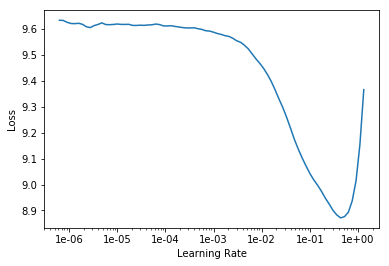

In [0]:
learn.recorder.plot(skip_end=10);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,5.458150,5.326368,0.186960,07:29
1,5.151121,5.039741,0.210416,07:32


epoch,train_loss,valid_loss,accuracy,time
0,5.002031,4.987146,0.216256,07:42
1,4.848481,4.722371,0.242696,07:43


epoch,train_loss,valid_loss,accuracy,time
0,4.858437,4.844409,0.231306,08:18
1,4.600290,4.552289,0.262153,08:18


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('12train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.412549,4.516192,0.265476,08:46
1,4.324831,4.460499,0.270647,08:45
2,4.274143,4.422407,0.275443,08:46
3,4.159180,4.417930,0.276177,08:47


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('12train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.221442,4.421705,0.275466,08:48
1,4.190004,4.394650,0.278114,08:48
2,4.134545,4.368842,0.281299,08:51
3,4.045060,4.368447,0.281861,08:52


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('12train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.091321,4.373766,0.280795,08:49
1,4.039201,4.355313,0.283222,08:49


In [0]:
learn.save_encoder('12train_wiki_subword_lm_enc')

### Classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '12train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('12train_subword_wiki_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"▁xx bo s ▁বাজার ▁বেড়া ই বার ▁সাধ ▁ র হিল ▁না - তবে ▁ প্রসন্ন ের ▁উপর ▁রাগ ▁ছিল ▁বল িয়া ▁একবার ▁দই য়ে হাটা ▁দেখি তে ▁লা গি লাম - গিয়া ▁প্রথমেই ▁দেখি লাম ▁যে , ▁সেখানে ▁খো দ ▁কমলা কান্ত ▁চক্র বর্ত্তী ▁নামে ▁গোয়াল া - দপ্তর রূপ ▁পচা ▁ ঘো লের ▁হাঁড়ি ▁লইয়া ▁বস িয়া ▁আছে - আপনি ▁ ঘো ল ▁ খাই তে ছে ,",bongkim
"▁xx bo s ▁কালা দীঘি র ▁ডাকা ই তির ▁পর ▁আমার ▁অ দৃষ্ট ে ▁যা হা ▁ঘট িয়া ছিল , ▁স্বামী ▁মহাশয় ▁এ ক্ষণে ▁আমার ▁কাছে ▁সব ▁শু নি লেন । ▁ র ম ণ ▁বাবু ▁ও ▁সুভাষ িণী ▁যে রূপ ▁ষড় ▁যন্ত্র ▁করিয়া ▁ তাঁ হা কে ▁কলিকাতা য় ▁লইয়া ▁ গিয়া ছিল , ▁তাহা ও ▁শু নি লেন । ▁একটু ▁রাগ ও ▁করি লেন । ▁বলি লেন ,",bongkim
"▁xx bo s ▁কক্ষের ▁ভিতর ▁ গিয়া ▁দেখি ল , ▁ জেব - উ ন্নি সা ▁হাসি তে ▁হাসি তে ▁ফুলের ▁একটা ▁কুকুর ▁গড় িতে ছেন , - ম বার কে র ▁মত ▁তার ▁মুখ টা ▁হইয়া ছে – আর ▁বাদশাহ দি গের ▁ সের পে ঁচ ▁কল গার ▁মত ▁তার ▁লেজ টা ▁হইয়া ছে । ▁ জেব - উ ন্নি সা ▁ প্রহর িণী কে ▁দেখি য়া ▁বলি ল",bongkim
"▁xx bo s ▁পারি লাম ▁না । ▁এ ▁সকল ▁এই ▁অঙ্গ ের ই ▁উপযুক্ত ▁– ▁এই ▁জন্য ▁পরা ই লাম । ▁আপনি ও ▁কখন ▁কখন ▁পর াইয়া ▁মুখ রা ▁বিদেশি নী কে ▁মনে ▁করি বেন । ” ▁নব কুমার ▁ চ ম ৎ কৃত ▁হইয়া ▁ ক হি লেন , ▁“ সে ▁কি ! ▁এ ▁যে ▁বহু মূল্য ▁অলঙ্কার । ▁আমি ▁এ ▁সব ▁ ল ই ব ▁কেন ?” ▁",bongkim
"▁xx bo s ▁আপনি ▁সহজেই ▁আমা দি গ কে ▁বহিষ্কৃত ▁করিয়া ▁দিবেন । ▁ প । ▁আর ▁যদি ▁আপনারা ▁অল্প ▁সেনা ▁লইয়া ▁না ▁আই সেন ? ▁ ম । ▁তবে ▁যুদ্ধ ▁করি বেন । ▁এই ▁বল িয়া ▁মহম্মদ ▁আলি ▁বিদায় ▁হইল । ▁সপ্তম ▁পরিচ্ছেদ ▁ : ▁চৌ রো দ্ধ র ণিক ▁মহম্মদ ▁আলি ▁বাহির ▁হইয়া ▁দৃষ্টি পথ াতীত ▁হইল ে , ▁অন্য ▁এক ▁জন ▁গুপ্ত দ্বার - নিক টে ▁",bongkim


In [0]:
data_clas = load_data(subsets, '12train_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('12train_wiki_subword_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


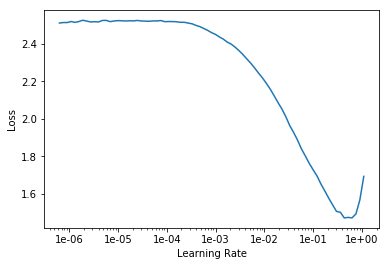

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('12train_wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.8**4),1e-2), moms=(0.8,0.7))
learn_cls.save('12train_wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.8**4),5e-3), moms=(0.8,0.7))
learn_cls.save('12train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.8**4),1e-3), moms=(0.8,0.7))
learn_cls.save('12train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.351537,0.086077,0.976809,02:53
1,0.082959,0.023208,0.994434,02:56


epoch,train_loss,valid_loss,accuracy,time
0,0.089966,0.028949,0.991651,03:20
1,0.036542,0.019714,0.992579,03:19


epoch,train_loss,valid_loss,accuracy,time
0,0.038169,0.014809,0.995362,04:45
1,0.023987,0.016808,0.996289,04:37


epoch,train_loss,valid_loss,accuracy,time
0,0.014811,0.017131,0.993506,05:51
1,0.009879,0.019783,0.993506,05:54
2,0.008994,0.015679,0.994434,05:48
3,0.005071,0.016633,0.994434,05:58


In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'12test.csv')

1356
Accuracy: 
0.9963126843657817
[('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('robindronath', 'tarashonkor'), ('robindronath', 'tarashonkor'), ('robindronath', 'shottojit_roy')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out , out.mean()

(array([0.991071, 1.      , 0.991228, 0.986547, 1.      , 1.      , 1.      , 1.      , 0.995595, 1.      , 0.991228,
        1.      ]), 0.9963057806483739)

## 14 Authors

### LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '14train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('14train_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '14train_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁রকম ▁খারাপ ▁হয়ে ▁পড়েছে । ▁সংখ্যায় ▁তারা ▁চির দিন ই ▁কা হার দের ▁চেয়ে ▁কম , ▁তার ▁উপর ▁লাঠি ▁ধরার ▁কাজ ▁করে ▁কুল ীন ▁হওয়ার ▁অ হ ঙ্কার ে ▁আজও ▁পর্যন্ত ▁তারা ▁গো ফে ▁তা ▁দিয়ে ▁আর ▁মুখে ▁হু ঙ্কার ▁দিয়ে ▁কাল ▁কাটিয়ে ▁এসেছে । ▁চাষ ▁করলেও ▁আট পৌর েরা ▁কোনো ▁কালে ই ▁চাষের ▁কাজ ▁ভাল ▁করে ▁না । ▁এতে ▁তাদের ▁মন ই ▁নাই । ▁চুরি - ডাক াতি তে"
1,"▁হয়েছে । ▁আপনার ▁মেয়ের ▁কোনো ▁ছবি ▁কি ▁আছে ? ▁তাকে ▁দেখতে ▁ইচ্ছা ▁করছে । ▁আমার ▁ ক ইল জার ▁ ম ই ধ্য ে ▁ছবি ▁আছে ▁আর ▁কোনো খানে ▁নাই । ▁রুস্তম ▁ভাই ! ▁আমি ▁সকালে ▁চলে ▁যা ব । ▁আপনার ▁জন্যে ▁পাগল ের ▁তেলের ▁ব্যবস্থা ▁করব । ▁এই ▁বিষয়ে ▁নিশ্চিন্ত ▁থাকেন । ▁আপনার ▁কোনো ▁শত্রু ▁থাকলে ▁নাম ঠি কানা ▁বলেন , ▁শেষ ▁করে ▁দিয়ে ▁যা ব , ▁তার ▁জন্যে"
2,"▁ছাত্র ▁জানতে ▁পারল ▁কিছু ▁মানুষের ▁চরিত্র ▁হন ন ▁করার ▁জন্যে ▁সে ▁ইচ্ছা ▁করলে ই ▁একটা ▁পত্রিকায় ▁মিথ্যা ▁সংবাদ ▁ছাপা তে ▁পারে ▁এবং ▁সেই ▁পত্রিকা ▁তাকে ▁রক্ষা ▁করবে । ▁আমাদের ▁দেশে ▁একটা ▁পত্রিকা ▁অনেক ▁সময় ▁রাজনৈতিক ▁দল , ▁পুলিশ , ▁ র ▁ ্যাব ▁এমনকি , ▁সরকার ▁থেকেও ▁বেশী ▁ক্ষমতাশালী । ▁এই ▁ঘটনাটি ▁আমার ▁চোখ ▁খুলে ▁দিয়েছে , ▁দেশের ▁একটা ▁খুব ▁গুরুত্বপূর্ণ ▁পত্রিকায় ▁( আমার ▁ব্যক্তিগত ▁যোগাযোগের ▁পরও ) ▁যদি ▁এরকম"
3,— ন য়ান ▁ওরফে ▁নন াইয়ের ▁দল । ▁সে ▁প্রশ্ন ▁করি ল — কি ? ▁এখানে ▁কি ? ▁— মে য়েট ▁ তোর ▁বাসায় ▁এসে ▁ঢুকে ছে । ▁— এস ে ছে ▁তা ’ — তোমরা ▁দাঁড়িয়ে ▁কেন ে ? ▁দলকে ▁দল ▁অ ট্ট হা সি ▁হা সিয়া ▁উ ঠি ল । ▁নি তাই ▁বলি ল — যা ও ▁তোমরা ▁এখান ▁থেকে । ▁নই লে ▁ হাঙ্গামা ▁হবে । ▁আমি
4,"▁ফি ফ টি ▁পার সেন্ট ের ▁বেশি ▁বই ▁পড়ে চে ? ▁অব ি শ্য ি ▁সবাই ▁যে ▁কিনে ▁পড়ে চে ▁তা ▁নয় ; ▁সিক্স টি ▁ ফাইভ ▁পার সেন্ট ▁ইস্ কুলের ▁লাইব্রেরি ▁থেকে ▁নিয়ে ▁পড়ে চে । ▁যারা ▁কি নো চে ▁তারা ▁এসে ▁বইয়ে ▁সই ▁নিয়ে ▁গেল । ▁তুল সী বাবু ▁ফেলুদা কে ▁বললেন , ▁আপনার ▁অপেক্ষা তেই ▁বসে ▁আছি । ▁একবার ▁আত্মা রামের ▁দর্শন টা ▁করে ▁ নিন ।"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


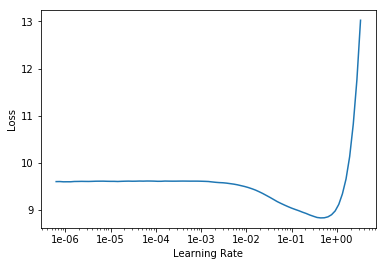

In [0]:
learn.freeze()
learn.lr_find();
learn.recorder.plot();

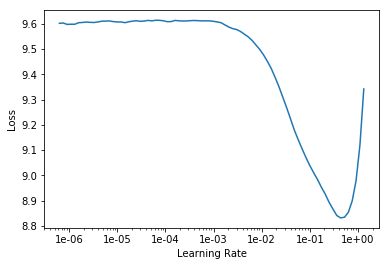

In [0]:
learn.recorder.plot(skip_end=10);

okay this is running

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,5.418075,5.380866,0.181160,07:22
1,5.139005,5.100408,0.203087,07:22


epoch,train_loss,valid_loss,accuracy,time
0,5.130114,5.043695,0.210517,07:30
1,4.863564,4.787333,0.235474,07:28


epoch,train_loss,valid_loss,accuracy,time
0,4.805257,4.906806,0.224133,08:02
1,4.562790,4.610963,0.254506,08:03


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('14train_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.488839,4.577379,0.257633,08:30
1,4.374043,4.519673,0.263232,08:30
2,4.252129,4.482963,0.267640,08:31
3,4.195413,4.478135,0.268445,08:32


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)
learn.save('14train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.192709,4.480588,0.267912,08:34
1,4.243721,4.452481,0.270235,08:34
2,4.152262,4.428723,0.273757,08:31
3,4.104909,4.428574,0.274226,08:33


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('14train_wiki_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.131775,4.433440,0.272903,08:32
1,4.053920,4.415045,0.275777,08:30


In [0]:
learn.save_encoder('14train_wiki_subword_lm_enc')

### Classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '14train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('14train_subword_wiki_clas.pkl')

In [0]:
data_clas = load_data(subsets,'14train_subword_wiki_clas.pkl',bs=bs)

In [0]:
data_clas.show_batch()

text,target
"▁xx bo s ▁ : ▁গৃহ াভি মুখে ▁“ ▁– ▁ ” ▁ ক পাল কুণ্ডল া ▁ধীরে ▁ধীরে ▁গৃহ াভি মুখে ▁চল ি লেন । ▁অতি ▁ধীরে ▁মৃদু ▁মৃদু ▁চল ি লেন । ▁তাহার ▁কারণ , ▁ ত নি ▁অতি ▁গভীর ▁চিন্তা ম গ্ন ▁হইয়া ▁যাই তে ছিলেন । ▁লুৎফ - উ ন্নি সার ▁সংবাদ ে ▁ ক পাল কুণ্ডল ার ▁একেবারে ▁ চিত্ত ভাব ▁ পরিবর্ত ্ত িত",bongkim
"▁xx bo s ▁কক্ষের ▁ভিতর ▁ গিয়া ▁দেখি ল , ▁ জেব - উ ন্নি সা ▁হাসি তে ▁হাসি তে ▁ফুলের ▁একটা ▁কুকুর ▁গড় িতে ছেন , - ম বার কে র ▁মত ▁তার ▁মুখ টা ▁হইয়া ছে – আর ▁বাদশাহ দি গের ▁ সের পে ঁচ ▁কল গার ▁মত ▁তার ▁লেজ টা ▁হইয়া ছে । ▁ জেব - উ ন্নি সা ▁ প্রহর িণী কে ▁দেখি য়া ▁বলি ল",bongkim
"▁xx bo s ▁ কাঁ হা ▁রূপ নগর ▁গড় , ▁ কাঁ হা ▁ও ঁ হা কা ▁রাজকুমারী ন্ ▁কি ▁দে মাগ – ইয়ে ▁বা ত্ ▁আপ ্ ▁কা ▁বোল নাই ▁ কিয়া ▁ জ রু র – হামা রা ▁শু ন নাই ▁ কিয়া ▁ জ রু র ? ▁মা । ▁স্ রে ফ ▁দে মাগ ▁বা প জান ! ▁ ল ৌ ণ্ড ী নে ▁বাদশাহ ে ▁আল",bongkim
"▁xx bo s ▁বিশাল া ক্ষি ▁ভক্ত ানা মার্ ত্তি নাশ িনি ▁ । ▁ ন মা মি ▁ শির সা ▁দেবী ং ▁বন্ধ নো হ স্তু ▁বি ম োচিত ঃ ▁ । । 14 ▁xx rep ▁6 ▁— ▁– ▁14 ▁আর্য ্যা স্তো ত্র ▁দে খ ▁দ্বাদশ ▁সংখ্যা - একটি ▁গীত ▁“ শো ন্ ▁ প্রসন্ন , ▁তো কে ▁একটি ▁গীত ▁শু নাই ব । ” ▁ প্রসন্ন ▁গোয়াল",bongkim
"▁xx bo s ▁হইতে ▁আদ লি ▁জাতীয় ▁একটি ▁লোক ▁ঘরে ▁প্রবেশ ▁করি ল । ▁মাথায় ▁গান্ধী - টু পি ▁ , ▁পরিধান ে ▁ খন্দ র ের ▁চাপ কন ▁ও ▁পায় জা মা ; ▁তাই ▁হঠাৎ ▁তাহা কে ▁চিনি তে ▁পারি ▁নাই । ▁সে ▁মাথার ▁টুপি ▁খু লিয়া ▁মে ঝো য় ▁আ ছাড় ▁মারি ল । ▁তারপর ▁বলিষ্ঠ ▁কণ্ঠে ▁বলি ল ▁ , ▁‘ শালা দের ▁ধরে ছি ▁স্যার ।",shordindu


In [0]:
data_clas = load_data(subsets, '14train_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('14train_wiki_subword_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


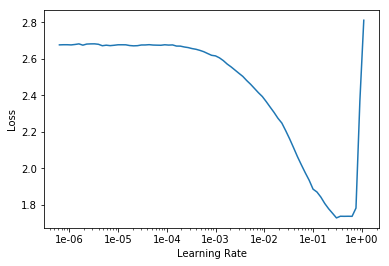

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('14train_wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.8**4),1e-2), moms=(0.8,0.7))
learn_cls.save('14train_wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.8**4),5e-3), moms=(0.8,0.7))
learn_cls.save('14train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.8**4),1e-3), moms=(0.8,0.7))
learn_cls.save('14train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.388567,0.068111,0.982873,04:59
1,0.106034,0.048400,0.986679,05:01


epoch,train_loss,valid_loss,accuracy,time
0,0.144111,0.051393,0.985728,05:41
1,0.044341,0.041162,0.987631,05:49


epoch,train_loss,valid_loss,accuracy,time
0,0.044280,0.052460,0.988582,08:36
1,0.028928,0.038491,0.992388,08:33


epoch,train_loss,valid_loss,accuracy,time
0,0.011207,0.033277,0.993340,10:57


In [0]:
learn_cls.load('14train_wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.8**4),1e-3), moms=(0.8,0.7))
learn_cls.save('14train_wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.014715,0.041817,0.991437,05:44
1,0.026728,0.037899,0.992388,05:43
2,0.012316,0.034183,0.993340,05:48
3,0.006736,0.035690,0.993340,05:43


In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'14test.csv')

1316
Accuracy: 
0.9954407294832827
[('manik_bandhopaddhay', 'shirshendu'), ('shirshendu', 'humayun_ahmed'), ('robindronath', 'tarashonkor'), ('shomresh', 'humayun_ahmed'), ('shunil_gongopaddhay', 'tarashonkor'), ('shunil_gongopaddhay', 'nihar_ronjon_gupta')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out , out.mean()

(array([1.      , 1.      , 0.989474, 0.994652, 0.994709, 0.994652, 0.989362, 0.994652, 1.      , 1.      , 1.      ,
        0.989247, 0.989474, 1.      ]), 0.9954444711669286)